In [2]:
import cv2
import numpy as np
import math
from PIL import Image
from IPython.display import display

In [3]:
def normalize_coordinate(x, y, width_equirect, height_equirect):
    x_prime = 2 * x / width_equirect - 1
    y_prime = 1 - 2 * y / height_equirect
    return (x_prime, y_prime)

In [4]:
def long_lat(x_prime, y_prime, lambda_0):
    longitude = math.pi * x_prime + lambda_0
    latitude = math.pi/2 * y_prime
    return (longitude, latitude)

In [5]:
def normalized_2D_fisheye_coord(latitude, longitude, aperture_in_rad, width, height, x, y):
    P_x = math.cos(latitude) * math.cos(longitude)
    P_y = math.cos(latitude) * math.sin(longitude)
    P_z = math.sin(latitude)
    
    theta = math.atan2(P_z, P_x)
    
    sqrt_for_r = math.sqrt(P_x**2 + P_z**2)
    if (P_y != 0):
        r = 2 * math.atan2(sqrt_for_r, P_y) / aperture_in_rad
    else:
        r = 0
    
    x_2 = (width - 1) * (theta / (2 * math.pi) + 0.5)
    y_2 = (height - 1) * (r / 2)
    
    return (x_2, y_2)

In [6]:
def compute_polar_angles(x_dest, y_dest, width_equirect, height_equirect):
    # -pi to pi
    theta = 2.0 * math.pi * (x_dest / width_equirect - 0.5)
    # -pi/2 to pi/2
    phi = math.pi * (y_dest / height_equirect - 0.5)
    return (theta, phi)

In [7]:
def vector_in_3D_space(theta, phi):
    x = math.cos(phi) * math.sin(theta)
    y = math.cos(phi) * math.cos(theta)
    z = math.sin(phi)
    return (x, y, z)

In [8]:
def calculate_fisheye_angle_radius(x, y, z, width, fov):
    theta = math.atan2(z, x)
    phi = math.atan2(math.sqrt(x**2 + z ** 2), y)
    r = width * phi / fov
    return (theta, phi, r)

In [9]:
def fish2sphere(x, y, width, height, fov, width_equirect, height_equirect):

    (theta_f, phi_f) = compute_polar_angles(x, y, width_equirect, height_equirect)
    (x_3d, y_3d, z_3d) = vector_in_3D_space(theta_f, phi_f)
    (theta_sphere, phi_sphere, r_sphere) = calculate_fisheye_angle_radius(x_3d, y_3d, z_3d, width, fov)
    
    # fisheye space 
    x_pfish = 0.5 * width + r_sphere * math.cos(theta_sphere)
    y_pfish = 0.5 * width + r_sphere * math.sin(theta_sphere)
    
    return (x_pfish, y_pfish)

In [10]:
def project_image(input_image_path, output_image_path):
    fisheye_image = cv2.imread(input_image_path)
    height, width = fisheye_image.shape[:2]
    
    width_equirect = width*2
    height_equirect = height
    
    fov = 190
    aperture = math.radians(fov)
    
    # Create a blank image for the unwrapped equirectangular projection
    unwrapped_image = np.zeros((height_equirect, width_equirect, 3), dtype=np.uint8)
    
    for x in range(width_equirect):
        for y in range(height_equirect):
            (x_pfish, y_pfish) = fish2sphere(x, y, width, height, aperture, width_equirect, height_equirect)
             
            # Map the pixel value from fisheye image to the unwrapped image 
            if 0 <= x_pfish < width and 0 <= y_pfish < height:
                unwrapped_image[y, x] = fisheye_image[int(y_pfish), int(x_pfish)]
                
    # Save the unwrapped image
    cv2.imwrite(output_image_path, unwrapped_image)
    

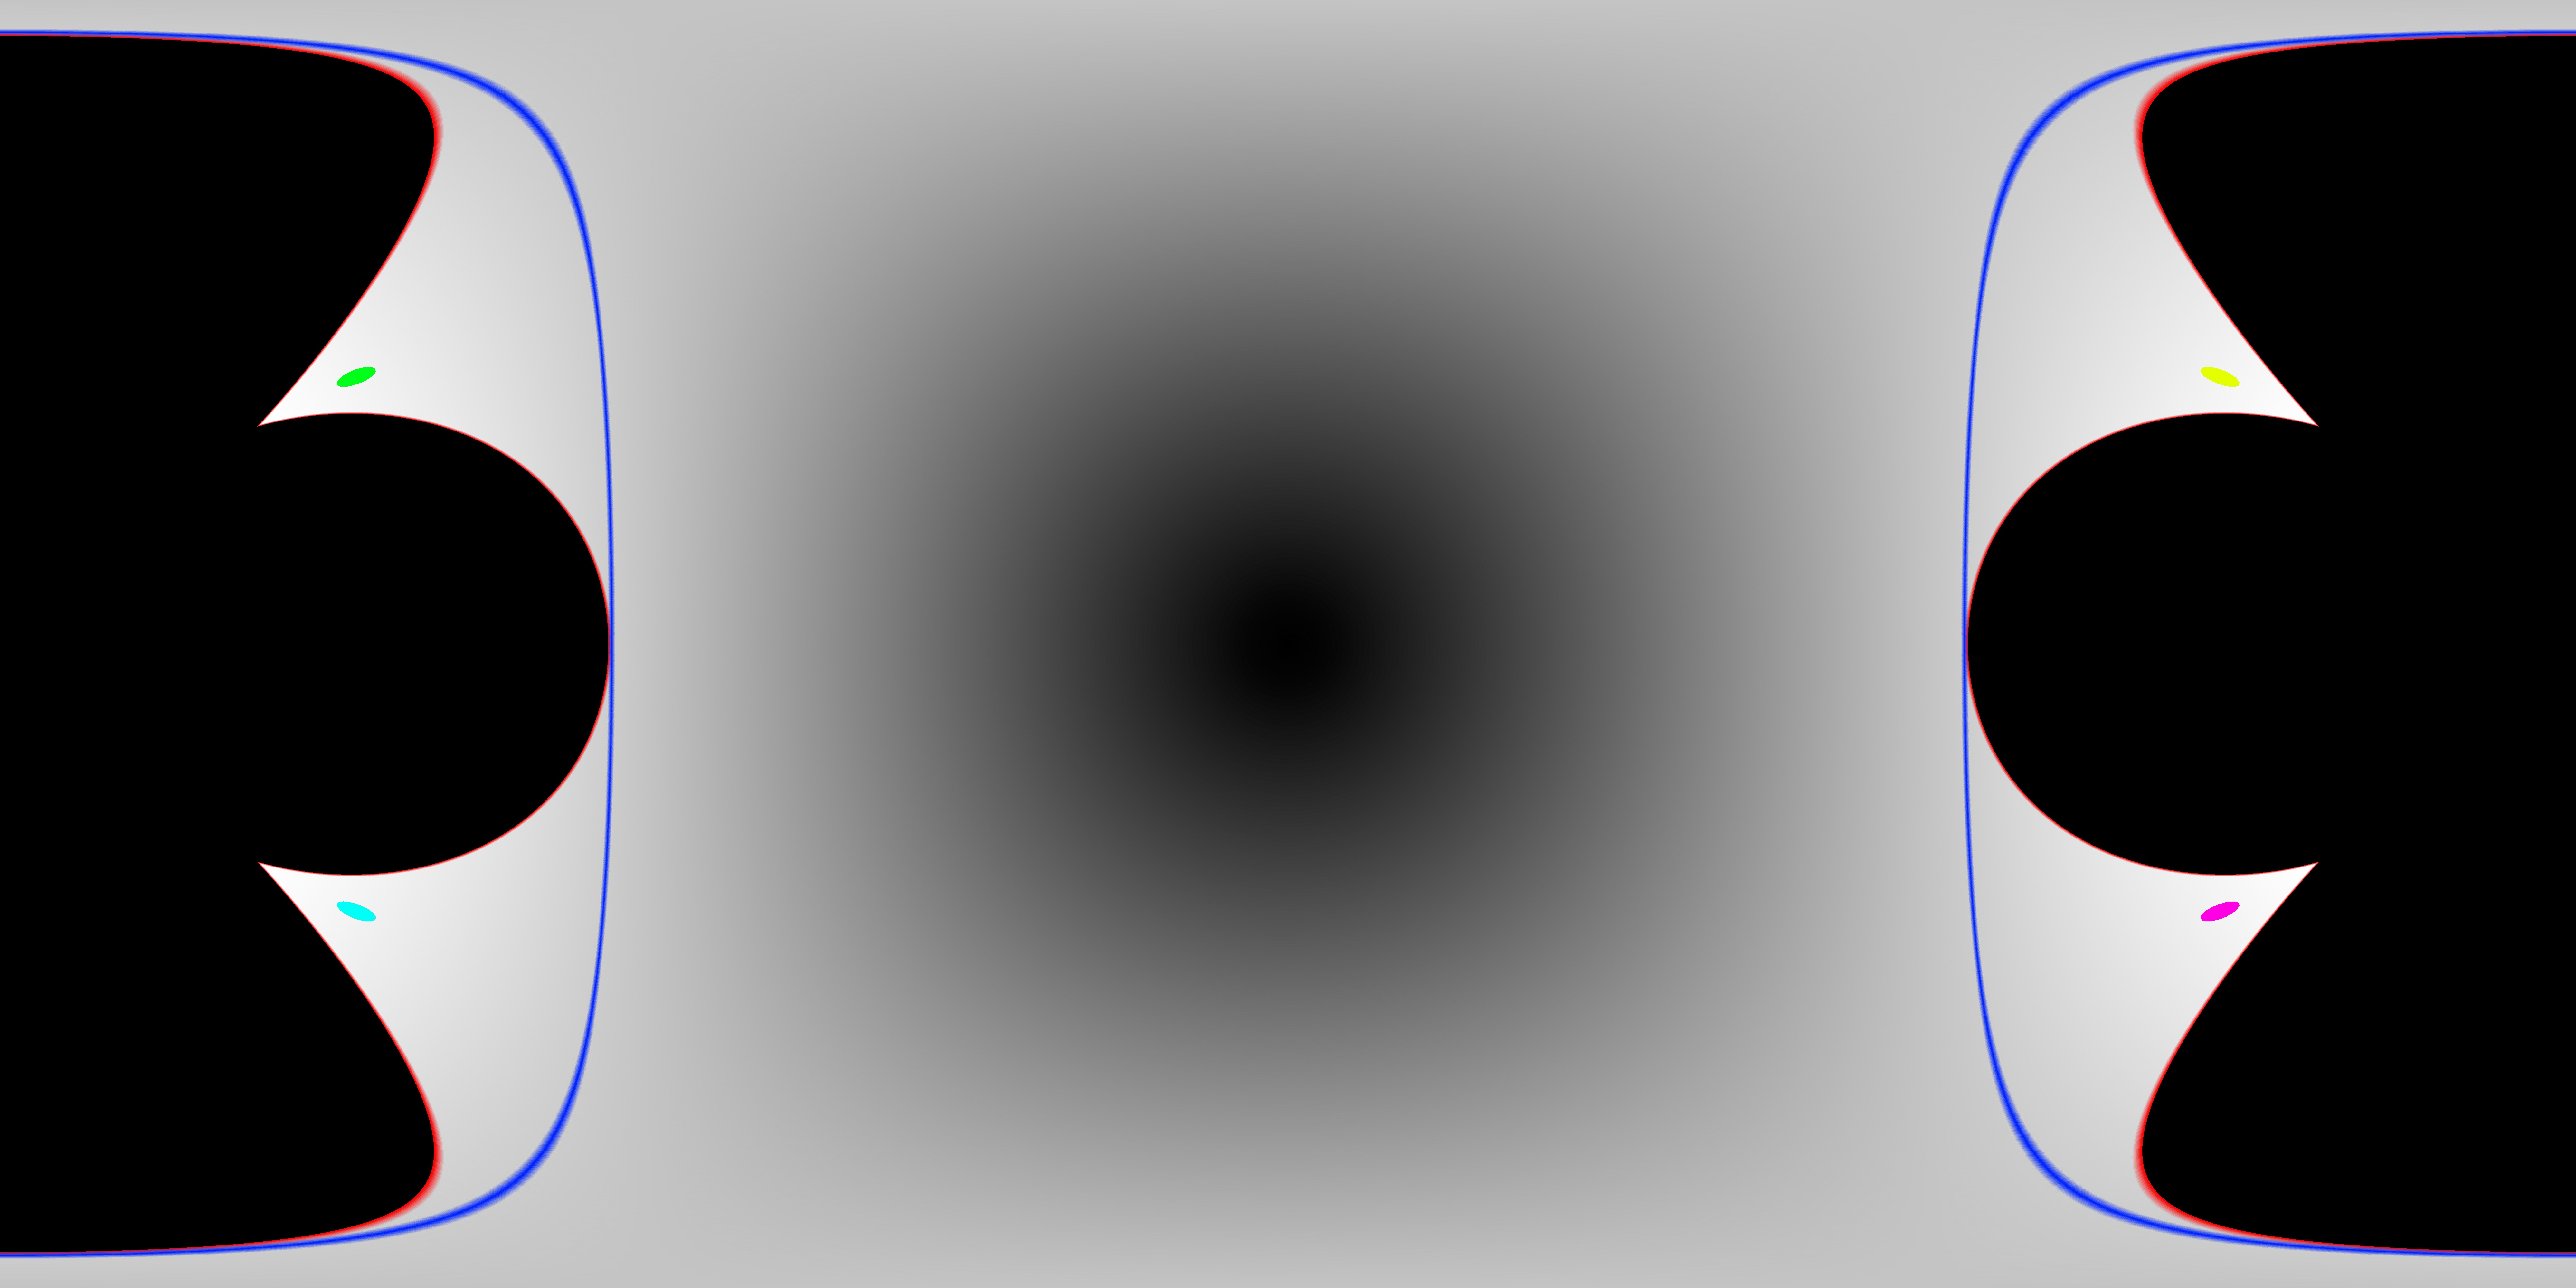

In [13]:
input_image_path = "Images/sample.jpg"
output_image_path = "Images_undistorted/test_undistort.jpg"

project_image(input_image_path, output_image_path)

img_test_undistort = Image.open(output_image_path)
display(img_test_undistort)

In [14]:
def split_image(input_image_path, output_image_path1, output_image_path2):
    # Open the image
    image = Image.open(input_image_path)

    # Get the width and height of the image
    width, height = image.size

    # Calculate the midpoint
    midpoint = width // 2

    # Split the image into left and right halves
    left_half = image.crop((0, 0, midpoint, height))
    right_half = image.crop((midpoint, 0, width, height))

    left_half.save(output_image_path1)
    right_half.save(output_image_path2)


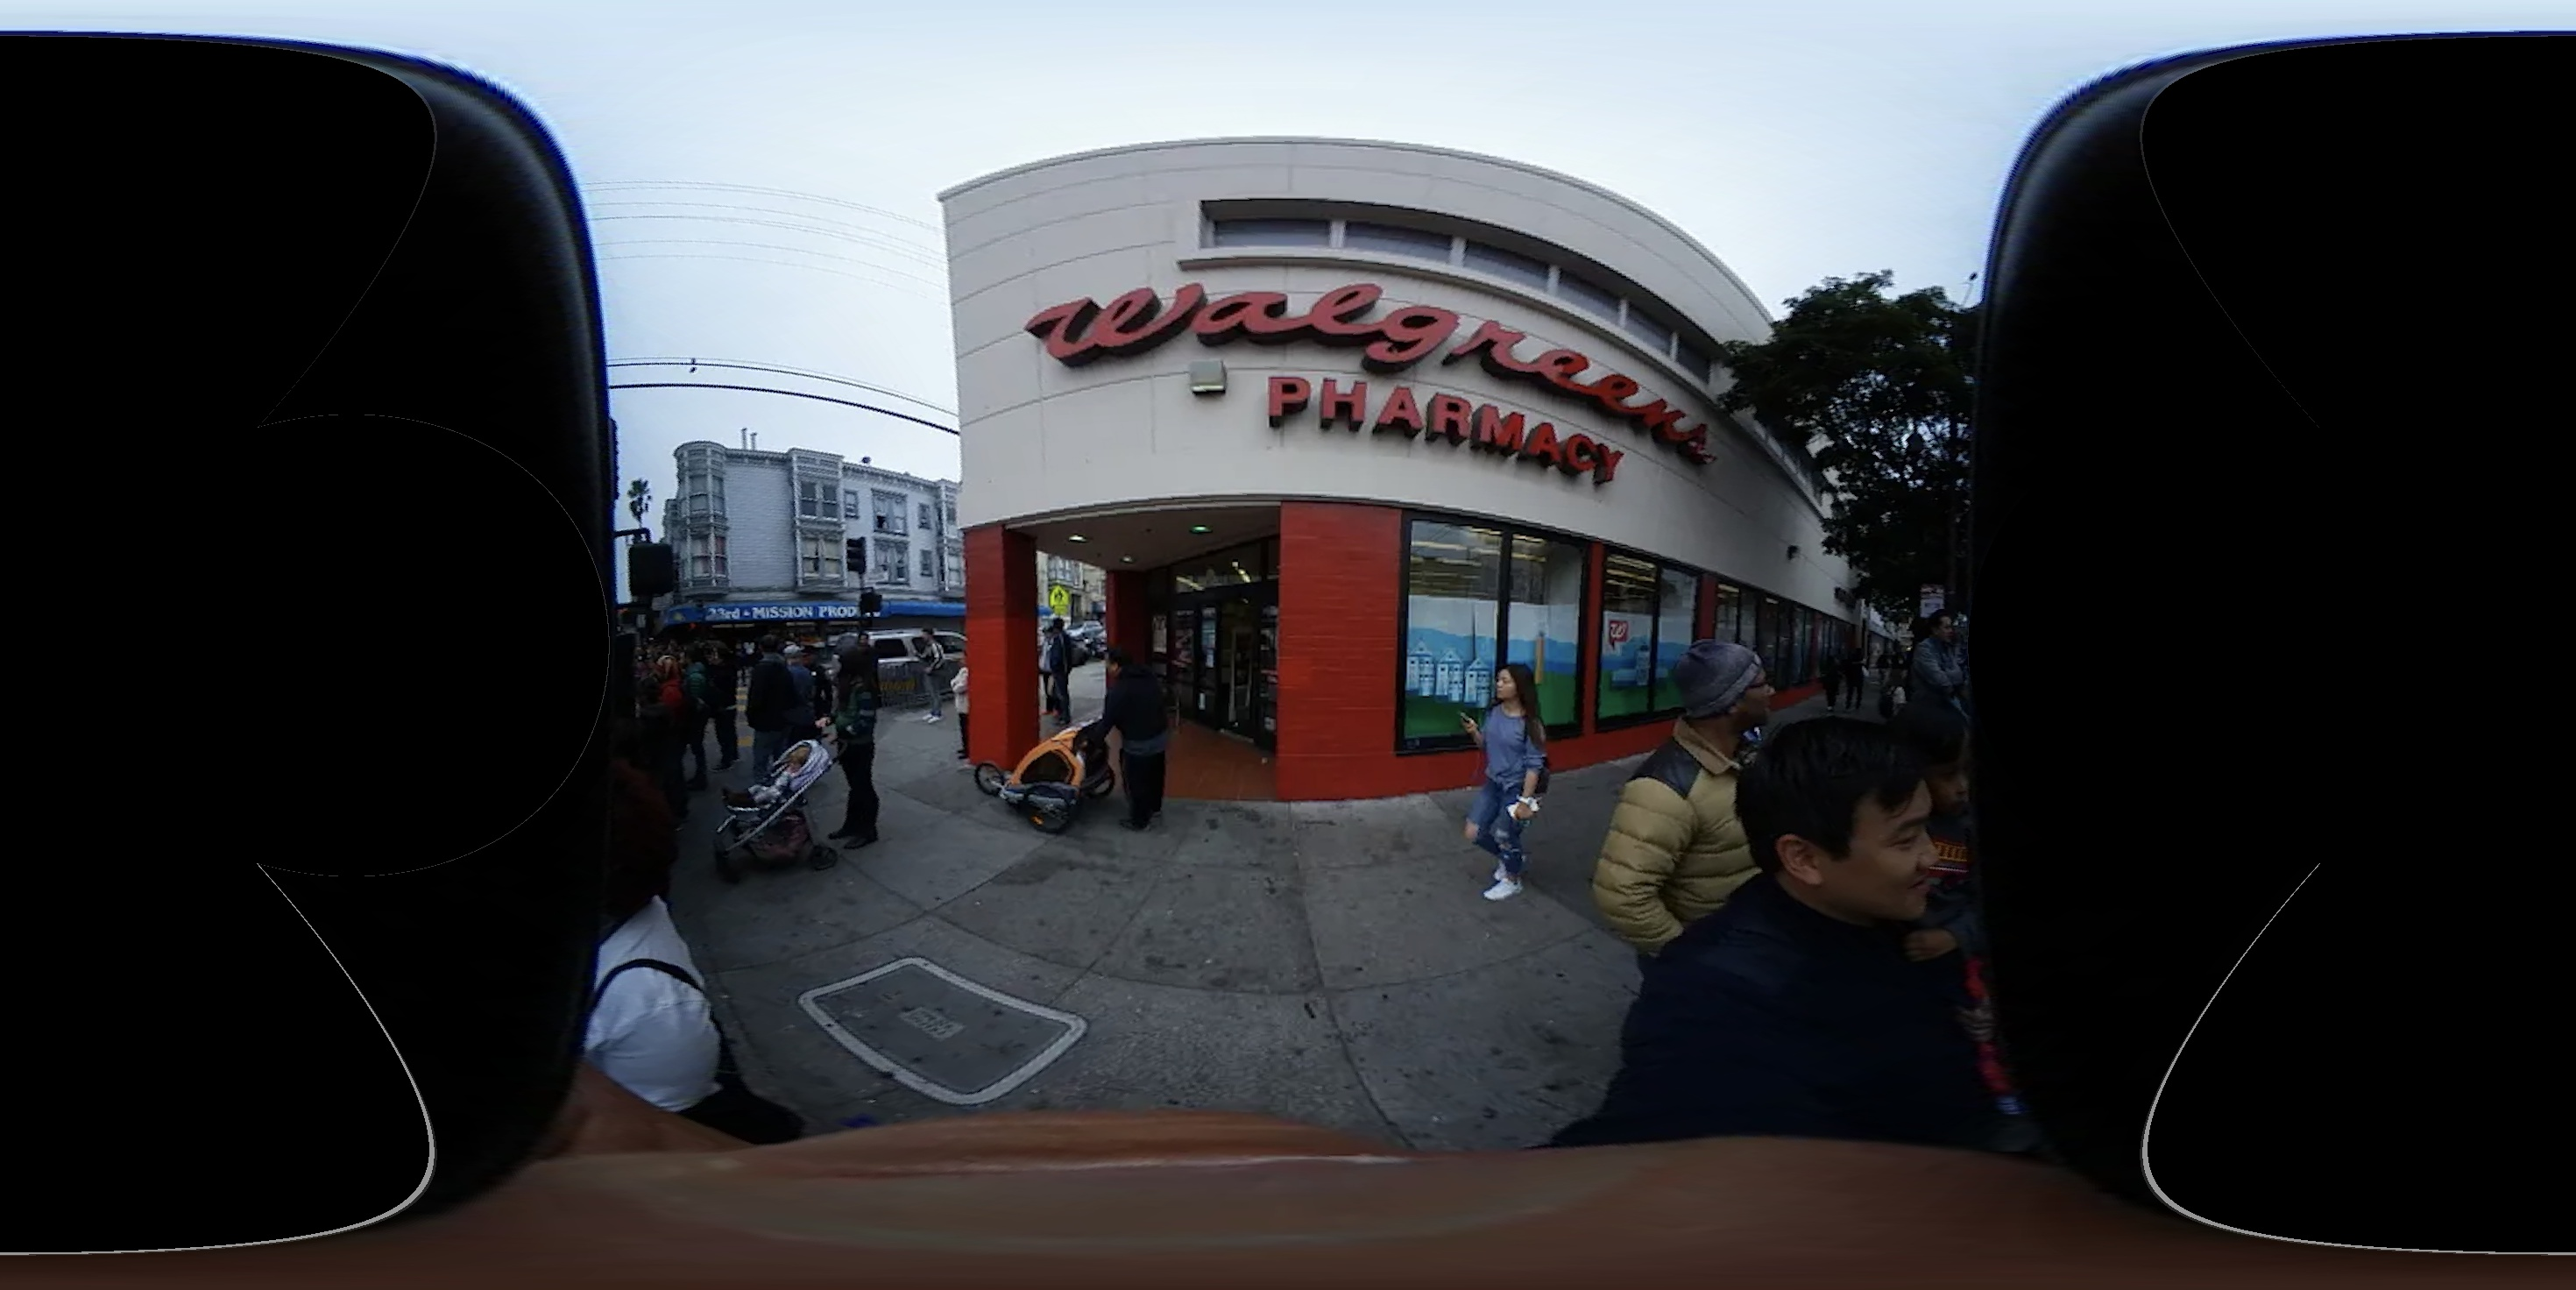

In [15]:
split_image("Images/img1.JPG", "Images/img1_left.jpg", "Images/img1_right.jpg")

input_image_path = "Images/unwrapped_walgreens_left.jpeg"
output_image_path = "Images_undistorted/unwrapped_walgreens_left.jpg"

input_image_path2 = "Images/unwrapped_walgreens_right.jpeg"
output_image_path2 = "Images_undistorted/unwrapped_walgreens_right.jpg"

project_image(input_image_path2, output_image_path2)
project_image(input_image_path, output_image_path)

img_test_undistort = Image.open(output_image_path)
display(img_test_undistort)


In [16]:
split_image("Images_undistorted/img1_right.JPG", "Images_overlap/img1_split_left.jpg", "Images_overlap/img1_split_right.jpg")


In [17]:
def crop_left_half(image_path, output_path):
    # Open the image
    image = Image.open(image_path)

    # Get the width and height of the image
    width, height = image.size

    # Calculate the midpoint
    midpoint = width // 2

    # Crop the left half of the image
    left_half = image.crop((0, 0, midpoint, height))

    left_half.save(output_path)


def crop_right_half(image_path, output_path):
    # Open the image
    image = Image.open(image_path)

    # Get the width and height of the image
    width, height = image.size

    # Calculate the midpoint
    midpoint = width // 2

    # Crop the left half of the image
    right_half = image.crop((midpoint, 0, width, height))
                            
    right_half.save(output_path)

In [20]:
def crop_middle_half(image_path, output_path):
    # Open the image
    image = Image.open(image_path)

    # Get the width and height of the image
    width, height = image.size

    # Calculate the quarter points
    quarter_point = width // 4
    three_quarter_point = 3 * quarter_point

    # Crop the middle half of the image
    middle_half = image.crop((quarter_point, 0, three_quarter_point, height))

    middle_half.save(output_path)


# Path to your image file
image_path = "Images_undistorted/img1_right.JPG"
# Crop the middle half of the image
middle_half_image = crop_middle_half(image_path, "Images_overlap/middle1_right.jpg")

crop_left_half("Images_undistorted/img1_left.JPG", "Images_overlap/left.jpg")
crop_left_half("Images_undistorted/img1_right.JPG", "Images_overlap/right.jpg")

In [19]:
def overlap_images(left_image_path, middle_image_path, right_image_path):
    # Open the images
    left_image = Image.open(left_image_path)
    middle_image = Image.open(middle_image_path)
    right_image = Image.open(right_image_path)

    # Get the dimensions of the images
    left_width, left_height = left_image.size
    middle_width, middle_height = middle_image.size
    right_width, right_height = right_image.size

    # Calculate the total width and height needed for the final image
    total_width = left_width + middle_width + right_width
    max_height = max(left_height, middle_height, right_height)

    # Create a new image with the calculated dimensions
    new_image = Image.new("RGB", (total_width, max_height))

    # Paste each image onto the new image
    new_image.paste(left_image, (0, 0))
    new_image.paste(middle_image, (left_width, 0))
    new_image.paste(right_image, (left_width + middle_width, 0))

    return new_image

# Paths to your image files
left_image_path = "Images_overlap/img1_split_left.jpg"
middle_image_path = "Images_overlap/middle.jpg"
right_image_path = "Images_overlap/img1_split_right.jpg"

# Overlap the images
result_image = overlap_images(left_image_path, middle_image_path, right_image_path)

# Save the result
result_image.save("Images_overlap/result_image.jpg")
